In [103]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.keras import backend as K
# from tensorflow.python.keras.models import Model
# from tensorflow.python.keras.layers import Flatten, Dense, Dropout
# from tensorflow.python.keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import ResNet50
# from tensorflow.python.keras.optimizers import Adam
# from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
import os
import numpy as np
import pandas as pd


In [18]:
train_path = './ml100-03-final/image_data/train'
test_path = './ml100-03-final/image_data/test'


In [3]:
# 資料路徑
DATASET_PATH  = './ml100-03-final'
# 影像大小
IMAGE_SIZE = (224, 224)
# 影像類別數
NUM_CLASSES = 5
# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 32

# Epoch 數
NUM_EPOCHS = 50
# 模型輸出儲存的檔案
WEIGHTS_FINAL = './ml100-03-final/flower-model.h5'
# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/image_data/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

Found 2823 images belonging to 5 classes.


In [4]:
# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print(train_batches.image_shape)

Class #0 = daisy
Class #1 = dandelion
Class #2 = rose
Class #3 = sunflower
Class #4 = tulip
(224, 224, 3)


In [5]:
# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
model = models.Sequential()
res50=ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
model.add(res50)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [7]:
#凍結resnet參數
for layer in model.layers:
    layer.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
#新增 layer
model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(BatchNormalization())

model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 49,280,389
Trainable params: 25,692,165
Non-trainable params: 23,588,224
_________________________________

In [9]:
model.compile(optimizer=optimizers.Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,                       
                        epochs = NUM_EPOCHS)

# 儲存訓練好的模型
model.save(WEIGHTS_FINAL)


Instructions for updating:
Use tf.cast instead.
Epoch 1/50
88/88 [==============================] - 53s 599ms/step - loss: 1.1934 - accuracy: 0.5625
Epoch 2/50
88/88 [==============================] - 47s 534ms/step - loss: 0.6741 - accuracy: 0.7671
Epoch 3/50
88/88 [==============================] - 45s 515ms/step - loss: 0.5634 - accuracy: 0.7900
Epoch 4/50
88/88 [==============================] - 46s 518ms/step - loss: 0.5130 - accuracy: 0.8137
Epoch 5/50
88/88 [==============================] - 45s 514ms/step - loss: 0.4517 - accuracy: 0.8381
Epoch 6/50
88/88 [==============================] - 45s 515ms/step - loss: 0.4199 - accuracy: 0.8531
Epoch 7/50
88/88 [==============================] - 45s 517ms/step - loss: 0.3910 - accuracy: 0.8667
Epoch 8/50
88/88 [==============================] - 46s 519ms/step - loss: 0.3691 - accuracy: 0.8642
Epoch 9/50
88/88 [==============================] - 46s 521ms/step - loss: 0.3601 - accuracy: 0.8722
Epoch 10/50
88/88 [========================

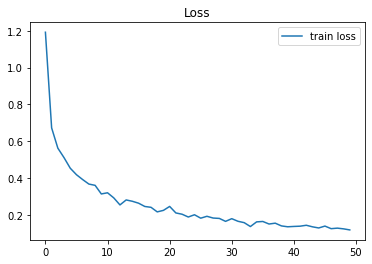

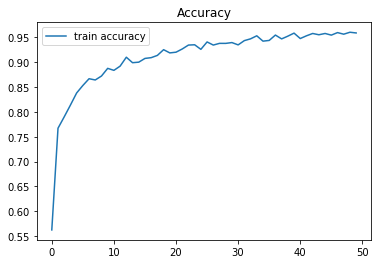

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline

train_loss = model.history.history["loss"]

train_acc = model.history.history["accuracy"]


plt.plot(range(len(train_loss)), train_loss, label="train loss")

plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")

plt.legend()
plt.title("Accuracy")
plt.show()

In [112]:
flower_mapping = {'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4}

                                    id  flower_class
0     0028624c49b3e0610ff9f1d111f5d532             2
1     002c30700185b7971369258b438070d5             4
2     00852f4f666acecd0c0d140365b42efd             4
3     00c08828fce04e360c732cac01edad9e             4
4     00d366e7877b6a78b104b57d67b60e6b             4
...                                ...           ...
1995  ff7eac29b6d7a33fbd8009677c3e9c58             1
1996  ffbc32a7b67dfe72b8d35d4b1b35fd6c             1
1997  ffea1f275c05accb0a6bfd1203620c7e             0
1998  ffeb2a1cf53464b6af937ab8af0c2946             4
1999  ffefcc68e2e7eed8b17b0b5b0f740538             1

[2000 rows x 2 columns]


In [ ]:
##test dimension

In [87]:
imgXX=os.path.join(test_path, '0028624c49b3e0610ff9f1d111f5d532.jpg')
imgXX = image.load_img(imgXX,target_size=(224,224))

imgXXX=image.img_to_array(imgXX) #to np array

print('imgXXX',imgXXX.shape)
imgXXXX = np.expand_dims(imgXX, axis=0)

print('imgXXXX',imgXXXX.shape)
print('predict 1st: ', model.predict_classes(imgXXXX).astype('int'))
model.predict_classes(imgXXXX)

imgXXX (224, 224, 3)
imgXXXX (1, 224, 224, 3)
predict 1st:  [2]


array([2], dtype=int64)

In [106]:
test_image_id=[]
test_images=[]
for img in os.listdir(test_path):
    test_image_id.append(img[:-4]) # remove  '.jpg'
    img = os.path.join(test_path, img)
    img = image.load_img(img, target_size=(224,224))# due to resnet input shape (n*224*224*3)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    test_images.append(img)
    

In [99]:
# stack up images list to pass for prediction
np_test_images = np.vstack(test_images)

In [100]:
model.predict_classes(np_test_images)

array([2, 4, 4, ..., 0, 4, 1], dtype=int64)

In [93]:
predict_test_result=model.predict_classes(np_test_images)

In [108]:
len(predict_test_result)

2000

In [110]:
sub = pd.DataFrame({'id': test_image_id, 'flower_class': predict_test_result})
sub.to_csv(DATASET_PATH+'/final_submit.csv', index=False)

In [113]:
sub

,id,flower_class
0,0028624c49b3e0610ff9f1d111f5d532,2
1,002c30700185b7971369258b438070d5,4
2,00852f4f666acecd0c0d140365b42efd,4
3,00c08828fce04e360c732cac01edad9e,4
4,00d366e7877b6a78b104b57d67b60e6b,4
...,...,...
1995,ff7eac29b6d7a33fbd8009677c3e9c58,1
1996,ffbc32a7b67dfe72b8d35d4b1b35fd6c,1
1997,ffea1f275c05accb0a6bfd1203620c7e,0
1998,ffeb2a1cf53464b6af937ab8af0c2946,4
